# Promotion Planning in Pharma Supply Chains

**Boğaziçi University**<br>
**Department of Industrial Engineering**<br>
IE492 - Graduation Project<br>
10.12.2023<br>

**Contributors**<br>
Ahmet Yiğit Doğan - 2018402105<br>
Yasin Seçal - 2018402135<br>
Barış Arslan - 2019402129<br>

**Advisors**<br>
Prof. Dr. Taner Bilgiç<br>
Prof. Dr. Mustafa Gökçe Baydoğan<br>

## 1. Project Description

In this project transaction data from a pharmaceutical supply chain will be used in order to understand the basic dynamics of the industry. On the basis of data analysis, efficient prediction methods will be designed and promotion strategies will be recommended.

In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import datetime as dt
import seaborn as sns
import math
import random

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from pandas.plotting import autocorrelation_plot
pd.options.mode.chained_assignment = None  # default='warn'

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats
import pylab

from utils import *
from pulp import *

## 2. Data Analysis

In [2]:
sales_data = pd.read_parquet("sale_data.parquet")
promo_data = pd.read_excel("promo_data.xlsx")

df_sales = pd.DataFrame(sales_data)
df_promo = pd.DataFrame(promo_data)

df_sales['Date'] = pd.to_datetime(df_sales['Date']).dt.date

df_sales.head()

,Date,LocationId,MainDistributorId,DistributorId,PackageId,ProductId,City,District,BrickId,PaidQty,FreeQty
0,2023-01-02,2873114,2879223,2878715,615,38,Kütahya,MERKEZ,430002,24,12
1,2023-01-16,2872993,2879223,2878715,615,38,Kütahya,ALTINTAŞ,430101,7,3
2,2023-01-18,2918671,2879223,2878715,615,38,Afyon,MERKEZ,30002,7,3
3,2023-01-19,2919833,2879223,2878715,615,38,Uşak,MERKEZ,640001,7,3
4,2023-01-02,2873114,2879223,2878715,616,38,Kütahya,MERKEZ,430002,24,12


In [3]:
df_promo.head()

,MProductId,BeginDate,EndDate,PaidQty,FreeQty
0,14,2022-01-01,2022-01-31 23:30:00,6,2
1,14,2022-01-01,2022-01-31 23:30:00,12,5
2,14,2022-01-01,2022-01-31 23:30:00,24,12
3,14,2022-02-01,2022-02-28 23:30:00,6,2
4,14,2022-02-01,2022-02-28 23:30:00,12,5


### 2.1. Merged Dataset (Sales Data + Promotion Data)

In [4]:
df = pd.read_parquet("Sales_Data_v2.parquet")
df["TotalQty"] = df["PaidQty"] + df["FreeQty"]
df.head()

,Date,LocationId,MainDistributorId,DistributorId,PackageId,ProductId,City,District,BrickId,PaidQty,FreeQty,isPromoted,Discount,BeginDate,EndDate,Promo,DStep,WeekStartDate,TotalQty
0,2023-01-02,2854453,2879223,2878715,568,29,Afyon,DİNAR,30601,10,0,0,0.0,NaT,NaT,None,0.0,2023-01-02,10
1,2022-06-29,2867763,2879249,2878795,568,29,Gaziantep,ŞEHİTKAMİL,270202,15,0,0,0.0,NaT,NaT,None,0.0,2022-06-27,15
2,2023-01-04,2877675,2879223,2878715,568,29,Uşak,BANAZ,640101,3,0,0,0.0,NaT,NaT,None,0.0,2023-01-02,3
3,2022-06-29,2918985,2879249,2878795,568,29,Şanlıurfa,HALİLİYE,630001,15,0,0,0.0,NaT,NaT,None,0.0,2022-06-27,15
4,2023-01-04,2854545,2879223,2878715,568,29,Afyon,MERKEZ,30001,20,0,0,0.0,NaT,NaT,None,0.0,2023-01-02,20


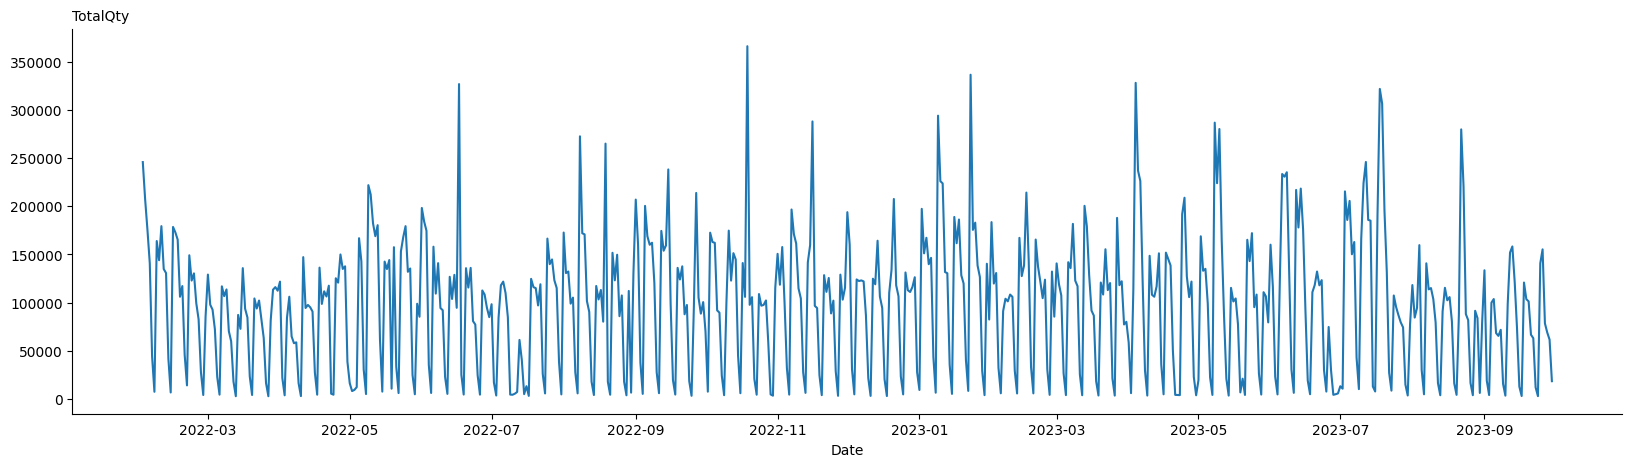

In [5]:
sales = df
sales = sales.groupby([sales['Date'].dt.date])['TotalQty'].sum()
sales.plot(figsize=(20,5), title="TotalQty")
plt.show()

## 3. Demand Forecasting

### 3.1. Forecasting Model 1

No aggregation, all products, single predictor (Free Quantity)

In [6]:
fit = smf.ols('TotalQty ~ FreeQty', df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                 1.158e+07
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:08:23   Log-Likelihood:            -3.2987e+07
No. Observations:             8931111   AIC:                         6.597e+07
Df Residuals:                 8931109   BIC:                         6.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1531      0.003   1570.571      0.000       5.147       5.160
FreeQty        2.6839      0.001   3402.640      0.000       2.682       2.685
==============================================================================
Omnibus:                 25864001.967   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   18404874264023.770
Skew:                          38.759   Prob(JB):                         0.00
Kurtosis:                    7035.228   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

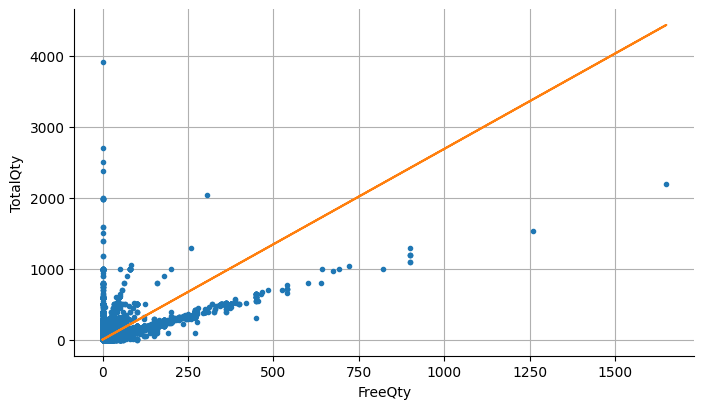

In [7]:
fig, ax = plt.subplots()
ax.plot(df.FreeQty, df.PaidQty, '.')
ax.plot(df.FreeQty, fit.predict())
ax.set(ylabel="TotalQty", xlabel="FreeQty")
ax.grid()

### 3.2. Forecasting Model 2

No aggregation, all products, multiple predictors (Free Quantity, is Promoted, Discount Ratio)

In [8]:
fit = smf.ols('TotalQty ~ FreeQty + isPromoted + Discount', df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 4.783e+06
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:08:50   Log-Likelihood:            -3.2421e+07
No. Observations:             8931111   AIC:                         6.484e+07
Df Residuals:                 8931107   BIC:                         6.484e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3427      0.003   1300.469      0.000       4.336       4.349
FreeQty        2.7883      0.001   3395.149      0.000       2.787       2.790
isPromoted    16.4981      0.015   1098.697      0.000      16.469      16.528
Discount     -69.7688      0.077   -901.883      0.000     -69.920     -69.617
==============================================================================
Omnibus:                 27281386.926   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   30288662149601.188
Skew:                          44.974   Prob(JB):                         0.00
Kurtosis:                    9024.346   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.3. Forecasting Model 3

Daily aggregation, all products, multiple predictors (Free Quantity, weekday)

In [9]:
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()
df_prod = df_prod.reset_index()

df_prod = df_prod.assign(
    weekday = df_prod.Date.apply(lambda x: x.weekday()),
    index = np.arange(len(df_prod)))

df_prod

,Date,ProductId,TotalQty,FreeQty,weekday,index
0,2022-02-01,14,4911,1117,1,0
1,2022-02-01,15,29604,9,1,1
2,2022-02-01,16,8034,1709,1,2
3,2022-02-01,20,25184,991,1,3
4,2022-02-01,21,19689,1031,1,4
...,...,...,...,...,...,...
12067,2023-09-30,72,2098,0,5,12067
12068,2023-09-30,76,270,0,5,12068
12069,2023-09-30,138,281,10,5,12069
12070,2023-09-30,148,418,41,5,12070


### 3.3.1. Daily Aggregation for All Products

In [10]:
d = df.groupby([df['Date'].dt.date])[["TotalQty", "FreeQty"]].sum()

d = d.assign(
    weekday = d.index.to_series().apply(lambda x: x.weekday()),
    index = np.arange(len(d)))

fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     2109.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          3.42e-273
Time:                        21:08:56   Log-Likelihood:                -6996.8
No. Observations:                 607   AIC:                         1.400e+04
Df Residuals:                     604   BIC:                         1.401e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.435e+04   3100.657     17.529      0.000    4.83e+04    6.04e+04
FreeQty        7.9546      0.177     44.832      0.000       7.606       8.303
weekday    -6666.6834    625.572    -10.657      0.000   -7895.244   -5438.123
==============================================================================
Omnibus:                       36.379   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.335
Skew:                           0.426   Prob(JB):                     4.80e-14
Kurtosis:                       4.303   Cond. No.                     3.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.3.2. Daily Aggregation for Single Product

In [11]:
d = df_prod[df_prod.ProductId == 39]
fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.899e+05
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:08:56   Log-Likelihood:                -4999.8
No. Observations:                 607   AIC:                         1.001e+04
Df Residuals:                     604   BIC:                         1.002e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2031.4547     72.774     27.915      0.000    1888.535    2174.375
FreeQty       13.4477      0.022    598.953      0.000      13.404      13.492
weekday     -275.1967     19.069    -14.432      0.000    -312.646    -237.748
==============================================================================
Omnibus:                      334.936   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4692.368
Skew:                           2.126   Prob(JB):                         0.00
Kurtosis:                      15.940   Cond. No.                     3.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.4. Forecasting Model 4

Daily aggregation, all products, multiple predictors (Free Quantity*dayofmonth)

In [12]:
d = df_prod[df_prod.ProductId == 39]
d["Date"] = pd.to_datetime(d.Date)
d["dayofmonth"] = d.Date.dt.day
d = d[["Date", "TotalQty", "FreeQty", "dayofmonth"]].set_index("Date")
one_hot = pd.get_dummies(d['dayofmonth']).astype(int)
d = d.drop('dayofmonth', axis = 1)
d = d.join(one_hot)
#.mul(d["FreeQty"]
d

,TotalQty,FreeQty,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-01,28611,1657,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-02-02,24162,1403,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-02-03,23027,1358,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-02-04,14880,854,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-02-05,4385,244,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-26,10190,664,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2023-09-27,3707,203,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2023-09-28,2702,133,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
d.columns = [str(i) for i in list(d.columns)]
equation = 'TotalQty ~ FreeQty + Q("1") + Q("2") + Q("3") + Q("4") + Q("5") + Q("6") + Q("7") + Q("8") + Q("9") + Q("10") + Q("11") + Q("12") + Q("13") + Q("14") + Q("15") + Q("16") + Q("17") + Q("18") + Q("19") + Q("20") + Q("21") + Q("22") + Q("23") + Q("24") + Q("25") + Q("26") + Q("27") + Q("28") + Q("29") + Q("30") + Q("31") - 1'
# Model: all predictors (31 days and FreeQty) and no intecept
fit = smf.ols(equation, d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     9271.
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:10:03   Log-Likelihood:                -5069.2
No. Observations:                 607   AIC:                         1.020e+04
Df Residuals:                     575   BIC:                         1.034e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FreeQty       13.5197      0.026    522.369      0.000      13.469      13.571
Q("1")      2208.9700    236.066      9.357      0.000    1745.313    2672.627
Q("2")      1434.1935    235.816      6.082      0.000     971.028    1897.359
Q("3")      1426.5047    235.833      6.049      0.000     963.305    1889.705
Q("4")      1222.8961    235.738      5.188      0.000     759.883    1685.909
Q("5")      1156.9419    235.786      4.907      0.000     693.834    1620.049
Q("6")      1111.3623    235.768      4.714      0.000     648.291    1574.434
Q("7")      1403.0333    235.784      5.951      0.000     939.931    1866.135
Q("8")      1112.1391    236.046      4.712      0.000     648.522    1575.756
Q("9")      1303.6180    235.985      5.524      0.000     840.121    1767.115
Q("10")     1177.0028    235.891      4.990      0.000     713.690    1640.315
Q("11")     1177.7920    235.985      4.991      0.000     714.294    1641.290
Q("12")     1021.5015    235.931      4.330      0.000     558.110    1484.893
Q("13")     1097.9612    237.234      4.628      0.000     632.009    1563.913
Q("14")     1646.8299    237.056      6.947      0.000    1181.228    2112.432
Q("15")     1292.8245    236.507      5.466      0.000     828.301    1757.348
Q("16")     1124.6665    238.649      4.713      0.000     655.937    1593.396
Q("17")     1054.5854    237.969      4.432      0.000     587.191    1521.980
Q("18")     1164.8939    236.502      4.926      0.000     700.381    1629.406
Q("19")      820.4449    240.851      3.406      0.001     347.389    1293.500
Q("20")     1061.2454    235.634      4.504      0.000     598.438    1524.053
Q("21")     1039.7114    235.906      4.407      0.000     576.369    1503.054
Q("22")      989.6961    236.295      4.188      0.000     525.590    1453.803
Q("23")     1007.4728    237.713      4.238      0.000     540.582    1474.364
Q("24")     1026.6670    235.916      4.352      0.000     563.306    1490.028
Q("25")      891.0239    235.971      3.776      0.000     427.553    1354.495
Q("26")     1026.3684    235.653      4.355      0.000     563.523    1489.214
Q("27")      853.6580    236.431      3.611      0.000     389.285    1318.031
Q("28")     1054.1253    235.591      4.474      0.000     591.400    1516.850
Q("29")      931.7554    248.330      3.752      0.000     444.010    1419.501
Q("30")      758.2163    248.333      3.053      0.002     270.465    1245.967
Q("31")     1123.6810    317.659      3.537      0.000     499.768    1747.594
==============================================================================
Omnibus:                      201.467   Durbin-Watson:                   1.116
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1466.245
Skew:                           1.272   Prob(JB):                         0.00
Ku

### 3.5. Coefficients of Each Product Type

In [14]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()
equation = 'TotalQty ~ FreeQty + Q("1") + Q("2") + Q("3") + Q("4") + Q("5") + Q("6") + Q("7") + Q("8") + Q("9") + Q("10") + Q("11") + Q("12") + Q("13") + Q("14") + Q("15") + Q("16") + Q("17") + Q("18") + Q("19") + Q("20") + Q("21") + Q("22") + Q("23") + Q("24") + Q("25") + Q("26") + Q("27") + Q("28") + Q("29") + Q("30") + Q("31") - 1'

df_prod = df_prod.reset_index()

stats = []
coeff = []

for p in products:
    d = df_prod[df_prod.ProductId == p]
    d["Date"] = pd.to_datetime(d.Date)
    d["dayofmonth"] = d.Date.dt.day
    d = d[["Date", "TotalQty", "FreeQty", "dayofmonth"]].set_index("Date")
    one_hot = pd.get_dummies(d['dayofmonth']).astype(int)
    d = d.drop('dayofmonth', axis = 1)
    d = d.join(one_hot)
    d.columns = [str(i) for i in list(d.columns)]
    fit = smf.ols(equation, d).fit()
    stats.append([fit.rsquared, fit.rsquared_adj, fit.aic])
    coeff.append(fit.params)

stats = pd.DataFrame(stats, columns = ["R-Squared", "Adj R-Squared", "AIC"])
coeff = pd.DataFrame(coeff)

stats.index = products
coeff.index = products

In [15]:
stats

,R-Squared,Adj R-Squared,AIC
14,0.963702,0.961745,8273.769851
16,0.947885,0.945076,8887.953340
20,0.846313,0.838027,11134.310387
21,0.826869,0.817535,10971.084408
29,0.495022,0.467797,12019.650519
30,0.986864,0.986155,9702.324887
32,0.982769,0.981840,8401.469398
38,0.980693,0.979652,9671.664564
39,0.998003,0.997896,10202.454591
41,0.979085,0.977957,8640.027005


In [16]:
coeff

,FreeQty,"Q(""1"")","Q(""2"")","Q(""3"")","Q(""4"")","Q(""5"")","Q(""6"")","Q(""7"")","Q(""8"")","Q(""9"")",...,"Q(""22"")","Q(""23"")","Q(""24"")","Q(""25"")","Q(""26"")","Q(""27"")","Q(""28"")","Q(""29"")","Q(""30"")","Q(""31"")"
14,4.438758,200.664319,118.883487,98.873295,99.613647,123.052741,62.774763,116.787009,40.729040,112.018051,...,184.148417,163.729708,188.271863,193.181344,171.265992,209.532014,223.725261,174.898312,130.151992,171.167490
16,4.726476,405.801066,211.663314,207.891135,186.873600,219.253369,198.588364,220.674801,157.960218,253.356729,...,285.705174,331.205241,309.628327,316.186762,354.638046,326.387072,323.238401,260.298764,182.585973,272.694279
20,15.427030,3542.280526,2253.712550,1919.641316,1192.677974,1456.287996,1799.574731,2138.983874,1175.085354,1687.573513,...,2141.722767,2122.287133,2054.649313,1912.758373,2078.294430,2011.177394,2380.571571,2088.975160,1419.596077,2058.308729
21,10.056604,4106.648238,2216.878424,2402.452006,1938.685971,1812.806739,1843.150119,2025.793529,1481.534107,1702.818075,...,2300.742534,2129.558576,2250.329318,2340.896305,2293.871761,2243.494413,2288.872707,1780.743255,1432.656237,2176.657020
29,10.662250,8787.307642,5812.767889,6493.355300,6910.866271,7224.214374,7069.612943,7435.291802,9043.115887,6676.609610,...,6565.840011,5489.691337,5938.472138,5371.057334,4254.636178,5571.109382,5392.795145,5286.387894,5308.265005,6013.807506
30,2.662247,1547.460469,1003.902514,950.892617,968.457951,872.762666,831.499776,754.230585,593.338889,695.127505,...,815.501483,796.748536,734.542021,914.161600,762.334152,775.303451,768.002419,648.490300,410.162472,631.421712
32,7.516776,232.090472,133.022882,119.063866,139.585629,125.141352,81.060825,162.168539,99.350728,156.495350,...,196.887919,190.181491,207.573417,223.517067,216.365672,171.052282,204.382778,179.602307,74.550794,238.159177
38,2.742507,852.288479,478.208245,591.164795,543.610576,531.938837,456.348039,429.801506,180.522674,349.275544,...,462.901797,446.916446,541.750580,534.385320,514.624839,535.772926,547.116188,409.507635,303.438775,543.681600
39,13.519736,2208.969993,1434.193540,1426.504735,1222.896119,1156.941876,1111.362258,1403.033321,1112.139062,1303.617978,...,989.696082,1007.472843,1026.666954,891.023892,1026.368420,853.657978,1054.125270,931.755396,758.216291,1123.680972
41,2.878529,293.734579,213.883652,221.256773,271.982439,271.094786,245.955527,243.801753,237.590528,169.427823,...,213.411919,183.283583,217.735422,236.119598,227.269888,184.289389,210.888701,176.206240,116.615544,232.824060


In [17]:
"""
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()

df_prod = df_prod.reset_index()

df_prod = df_prod.assign(
    weekday = df_prod.Date.apply(lambda x: x.weekday()),
    index = np.arange(len(df_prod)))

rows = []

for p in products:
    d = df_prod[df_prod.ProductId == p]
    fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
    rows.append([fit.rsquared, fit.rsquared_adj, fit.aic,
                 fit.params["Intercept"], fit.pvalues["Intercept"], 
                 fit.params["FreeQty"], fit.pvalues["FreeQty"],
                 fit.params["weekday"], fit.pvalues["weekday"]])

results = pd.DataFrame(rows, columns = ["R-Squared", "Adj R-Squared", "AIC",
                                        "Coeff. Intercept (Base Demand)", "p-value (Int.)",
                                        "Coeff. FreeQty (Promo Sens.)", "p-value (FQty.)",
                                        "Coeff weekday", "p-value (weekday)"])

results.index = products
results
"""

'\nproducts = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]\ndf_prod = df\ndf_prod = df_prod.groupby([df_prod[\'Date\'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()\n\ndf_prod = df_prod.reset_index()\n\ndf_prod = df_prod.assign(\n    weekday = df_prod.Date.apply(lambda x: x.weekday()),\n    index = np.arange(len(df_prod)))\n\nrows = []\n\nfor p in products:\n    d = df_prod[df_prod.ProductId == p]\n    fit = smf.ols(\'TotalQty ~ FreeQty + weekday\', d).fit()\n    rows.append([fit.rsquared, fit.rsquared_adj, fit.aic,\n                 fit.params["Intercept"], fit.pvalues["Intercept"], \n                 fit.params["FreeQty"], fit.pvalues["FreeQty"],\n                 fit.params["weekday"], fit.pvalues["weekday"]])\n\nresults = pd.DataFrame(rows, columns = ["R-Squared", "Adj R-Squared", "AIC",\n                                        "Coeff. Intercept (Base Demand)", "p-value (Int.)",\n                                        "Coeff. FreeQty (Promo Sen

### 3.6. Assessing the Predictive Power of the Model

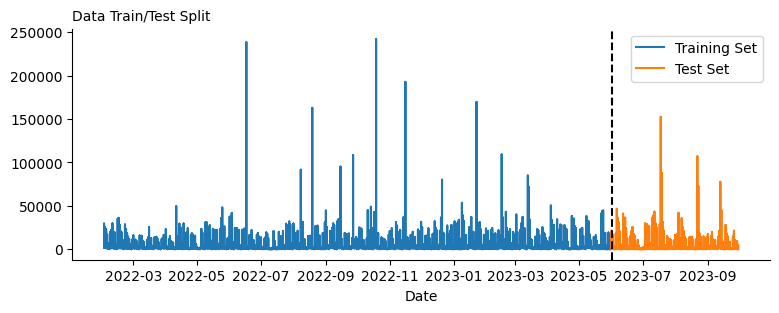

In [17]:
# All products

split_date = dt.date(2023, 6, 1)
train = df_prod[df_prod["Date"] < split_date]
test = df_prod[df_prod["Date"] >= split_date]

fig, ax = plt.subplots(figsize=(9, 3))
train[["Date", "TotalQty"]].set_index("Date").plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test[["Date", "TotalQty"]].set_index("Date").plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

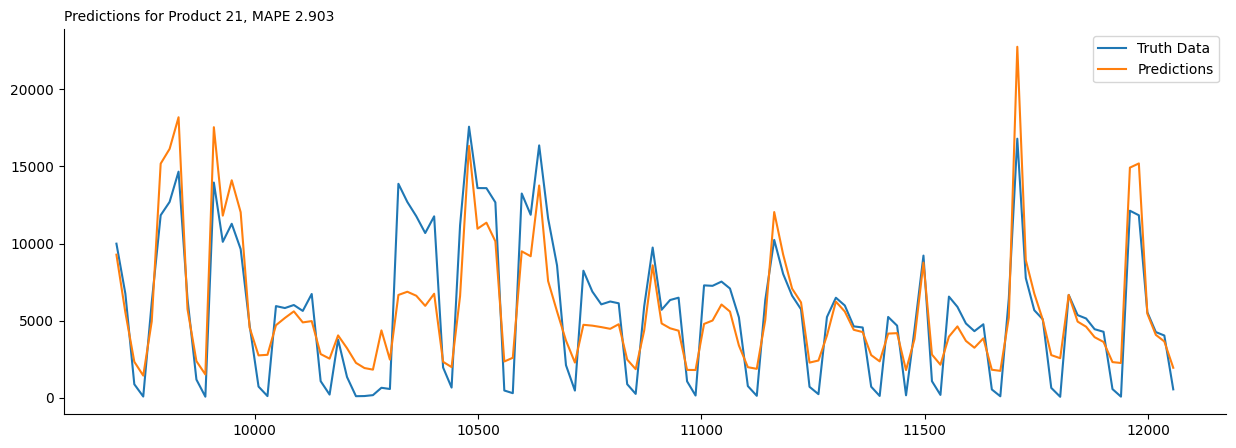

In [18]:
# Single product

df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()
df_prod = df_prod.reset_index()

# Parameters
equation = 'TotalQty ~ FreeQty + Q("1") + Q("2") + Q("3") + Q("4") + Q("5") + Q("6") + Q("7") + Q("8") + Q("9") + Q("10") + Q("11") + Q("12") + Q("13") + Q("14") + Q("15") + Q("16") + Q("17") + Q("18") + Q("19") + Q("20") + Q("21") + Q("22") + Q("23") + Q("24") + Q("25") + Q("26") + Q("27") + Q("28") + Q("29") + Q("30") + Q("31") - 1'
prod_id = 21
split_date = dt.datetime(2023, 6, 1)    # (2023, 6, 1) -> 80-20 split

# Data prep.

d = df_prod[df_prod.ProductId == prod_id]
d["Date"] = pd.to_datetime(d.Date)
d["dayofmonth"] = d.Date.dt.day
d = d[["Date", "TotalQty", "FreeQty", "dayofmonth"]]
one_hot = pd.get_dummies(d['dayofmonth']).astype(int)
d = d.drop('dayofmonth', axis = 1)
d = d.join(one_hot)
d.columns = [str(i) for i in list(d.columns)]
train = d[d["Date"] < split_date]
test = d[d["Date"] >= split_date]

# Fit model, get predictions
fit = smf.ols(equation, train).fit()
pred = fit.get_prediction(test)
test["Predictions"] = pred.predicted

# MAPE
mape = round(mean_absolute_percentage_error(test.TotalQty, test.Predictions), 3)

# Plot
ax = test[["TotalQty"]].plot(figsize=(15, 5))
test['Predictions'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Predictions for Product {}, MAPE {}'.format(prod_id, mape))
plt.show()

In [19]:
# All MAPEs

mape_all = {}

for p in products:
    d = df_prod[df_prod.ProductId == p]
    d["Date"] = pd.to_datetime(d.Date)
    d["dayofmonth"] = d.Date.dt.day
    d = d[["Date", "TotalQty", "FreeQty", "dayofmonth"]]
    one_hot = pd.get_dummies(d['dayofmonth']).astype(int)
    d = d.drop('dayofmonth', axis = 1)
    d = d.join(one_hot)
    d.columns = [str(i) for i in list(d.columns)]
    train = d[d["Date"] < split_date]
    test = d[d["Date"] >= split_date]

    # Fit model, get predictions
    fit = smf.ols(equation, train).fit()
    pred = fit.get_prediction(test)
    test["Predictions"] = pred.predicted

    # MAPE
    mape = round(mean_absolute_percentage_error(test.TotalQty, test.Predictions), 3)
    mape_all[p] = mape

mape_all

{14: 1.422,
 16: 1.213,
 20: 1.53,
 21: 2.903,
 29: 2.28,
 30: 1.54,
 32: 0.31,
 38: 0.561,
 39: 1.353,
 41: 0.742,
 49: 1.094,
 138: 0.402,
 148: 1.718}

### 3.7. Predictions for Optimization Model

In [20]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]

I=len(products)
T=30
PHorizon = list(range(0, T))
Base_Demand = np.array(coeff.drop("FreeQty", axis=1))
# Base_Demand = np.zeros((I, T), dtype = int)
Promo_Sensitivity = np.array(coeff.FreeQty)
# Promo_Sensitivity = np.zeros(I, dtype = float)

In [21]:
Promo_Sensitivity

array([ 4.43875835,  4.72647636, 15.42703003, 10.05660351, 10.66224964,
        2.66224722,  7.51677644,  2.74250687, 13.51973594,  2.87852914,
        4.91165667, 18.01591052,  6.474848  ])

### 3.8. Weekday Effect on Promotion Sensitivity

In [22]:
d = df
d = d.groupby([d['Date'].dt.date, d["ProductId"]])[["TotalQty", "FreeQty"]].sum()
d = d.reset_index()

d = d.assign(
    dayofweek = d.Date.apply(lambda x: x.weekday()))
one_hot = pd.get_dummies(d['dayofweek']).astype(int)
d = d.drop('dayofweek', axis = 1)
d = d.join(one_hot.mul(d["FreeQty"], axis=0))
d.columns = [str(i) for i in list(d.columns)]
d

,Date,ProductId,TotalQty,FreeQty,0,1,2,3,4,5,6
0,2022-02-01,14,4911,1117,0,1117,0,0,0,0,0
1,2022-02-01,15,29604,9,0,9,0,0,0,0,0
2,2022-02-01,16,8034,1709,0,1709,0,0,0,0,0
3,2022-02-01,20,25184,991,0,991,0,0,0,0,0
4,2022-02-01,21,19689,1031,0,1031,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12067,2023-09-30,72,2098,0,0,0,0,0,0,0,0
12068,2023-09-30,76,270,0,0,0,0,0,0,0,0
12069,2023-09-30,138,281,10,0,0,0,0,0,10,0
12070,2023-09-30,148,418,41,0,0,0,0,0,41,0


In [23]:
fit = smf.ols('TotalQty ~ Q("0") + Q("1") + Q("2") + Q("3") + Q("4") + Q("5") + Q("6")', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     699.1
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:11:01   Log-Likelihood:            -1.2304e+05
No. Observations:               12072   AIC:                         2.461e+05
Df Residuals:                   12064   BIC:                         2.462e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3421.5955     64.780     52.819      0.000    3294.617    3548.574
Q("0")         3.6397      0.122     29.768      0.000       3.400       3.879
Q("1")         3.6576      0.112     32.603      0.000       3.438       3.878
Q("2")         4.5698      0.107     42.589      0.000       4.359       4.780
Q("3")         3.0241      0.152     19.940      0.000       2.727       3.321
Q("4")         5.4131      0.163     33.272      0.000       5.094       5.732
Q("5")        -4.1370      0.925     -4.471      0.000      -5.951      -2.323
Q("6")       -32.5664      4.892     -6.657      0.000     -42.156     -22.977
==============================================================================
Omnibus:                    14333.945   Durbin-Watson:                   2.305
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4129421.700
Skew:                           5.972   Prob(JB):                         0.00
Kurtosis:                      92.816   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4. Optimization Model

max $\;$ $\sum\limits _{i} ^{I} \sum\limits _{t} ^{T} P_{i,t}$  

st.  

$\;\;\;\;\;\;$ $P_{i,t}+F{i,t} \le BaseDemand_{i,t} + PromoSensitivity_{i}*F_{i,t}$  $\;\;\;\;\;\;$  $\forall{i,t}$

$\;\;\;\;\;\;$ $F_{i,t} \le X_{i,t}*M$  $\;\;\;\;\;\;$  $\forall{i,t}$ 

$\;\;\;\;\;\;$ $F_{i,t} \ge X_{i,t}-0.5$  $\;\;\;\;\;\;$  $\forall{i,t}$

$\;\;\;\;\;\;$ $\sum\limits _{t} ^{T} X_{i,t} = L_{i} $  $\;\;\;\;\;\;$  $\forall{i}$   

$\;\;\;\;\;\;$ $L_{i} \le LongestPromotion$  $\;\;\;\;\;\;$  $\forall{i,t}$ 

$\;\;\;\;\;\;$ $L_{i} \ge ShortestPromotion$  $\;\;\;\;\;\;$  $\forall{i,t}$ 

$\;\;\;\;\;\;$ $\sum\limits _{i} ^{I} X_{i,t} \le DailyPromotedProductLimit_{i}$  $\;\;\;\;\;\;$  $\forall{t}$  

$\;\;\;\;\;\;$ $\sum\limits _{t} ^{T} P_{i,t} \le TotalPaidQuantityLimit_{i}$  $\;\;\;\;\;\;$  $\forall{i}$ 

$\;\;\;\;\;\;$ $\sum\limits _{t} ^{T} F_{i,t} \le TotalFreeQuantityLimit_{i}$  $\;\;\;\;\;\;$  $\forall{i}$   

$\;\;\;\;\;\;$ $P_{i,t} \le PaidQuantityLimit_{i}$  $\;\;\;\;\;\;$  $\forall{i,t}$ 

$\;\;\;\;\;\;$ $F_{i,t} \le FreeQuantityLimit_{i}$  $\;\;\;\;\;\;$  $\forall{i,t}$ 

$\;\;\;\;\;\;$ $P_{i,t} \ge 0$  $\;\;\;\;\;\;$  $\forall{i,t}$

$\;\;\;\;\;\;$ $F_{i,t} \ge 0$  $\;\;\;\;\;\;$  $\forall{i,t}$

$\;\;\;\;\;\;$ $X_{i,t} \in \{0,1\}$



**Decision Variables**<br>
$P_{i,t}$ - Paid quantity for product i at time t<br>
$F_{i,t}$ - Free quantity for product i at time t<br>
$X_{i,t}$ - Binary variable that is equal to 1 if the product i is promoted at time t, and 0 otherwise<br>
$L_{i}$ -  Promotion length<br>

**Parameters**<br>
$T$ - Number of days in the time horizon<br>
$I$ - Number of product types<br>
$Base\;Demand_{i,t}$ - Demand without promotion, for product i at time t<br>
$Promo\;Sensitivity_{i}$ - Effect on the base demand for a given free quantity of product i<br>
$Total\;Paid\;Quantity\;Limit_{i}$ -  Capacity of total paid quantity of product i throughout the time horizon<br>
$Total\;Free\;Quantity\;Limit_{i}$ -  Capacity of total free quantity of product i throughout the time horizon<br>
$Paid\;Quantity\;Limit_{i}$ - Maximum daily amount allowed for the paid quantity of product i<br>
$Free\;Quantity\;Limit_{i}$ - Maximum daily amount allowed for the free quantity of product i<br>



In [42]:
#LP MAXIMIZATION MODEL

Promo_Model = LpProblem("Pharma_Promotion_Model", LpMaximize)

### 4.1. Parameters

In [39]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]

T=30 # end of promotion horizon
PHorizon = list(range(0, T))
AugHorizon = list(range(1, T))

I=len(products) # product count 
Products = list(range(0, I))

Total_PaidQty_Limit = 10000000
Total_FreeQty_Limit = 10000

'''
#RANDOM DEMAND AND PROMO_SENSITIVITY GENERATOR

Base_Demand = np.zeros((I, T), dtype = int)
for i in Products:
    for t in PHorizon:
        Base_Demand[i][t] = random.randint(4000,6000)
    
Promo_Sensitivity = np.zeros(I, dtype = float)
for i in Products:
    Promo_Sensitivity[i] = random.uniform(2,3)
'''

'\n#RANDOM DEMAND AND PROMO_SENSITIVITY GENERATOR\n\nBase_Demand = np.zeros((I, T), dtype = int)\nfor i in Products:\n    for t in PHorizon:\n        Base_Demand[i][t] = random.randint(4000,6000)\n    \nPromo_Sensitivity = np.zeros(I, dtype = float)\nfor i in Products:\n    Promo_Sensitivity[i] = random.uniform(2,3)\n'

### 4.2. Decision Variables

In [40]:
#Paid Quantity
PaidQtyLimit = Total_PaidQty_Limit/T
P = LpVariable.dicts("Paid_Quantity",(Products,PHorizon),lowBound=0, upBound=PaidQtyLimit, cat='Integer')

#Free Quantity
FreeQtyLimit = Total_FreeQty_Limit/T
F = LpVariable.dicts("Free_Quantity",(Products,PHorizon),lowBound=0, upBound=FreeQtyLimit, cat='Integer')

#Is Product "i" at Time "t" Promoted?
X = LpVariable.dicts("IsPromoted",(Products,PHorizon),cat='Binary')

#Promotion Length
Longest_Promo = 30
Shortest_Promo = 20
L = LpVariable.dicts("Promo_Length",Products,lowBound=Shortest_Promo, upBound=Longest_Promo, cat='Integer')

#Promotion Starting Date
S = LpVariable.dicts("Promo_Start",(Products,PHorizon),cat='Binary')

#Promotion Ending Date
E = LpVariable.dicts("Promo_End",(Products,PHorizon),cat='Binary')

### 4.3. Objective Function

In [43]:
Total_Paid_Quantity = lpSum(lpSum(P[i][t] for i in Products) for t in PHorizon)
Total_Free_Quantity = lpSum(lpSum(F[i][t] for i in Products) for t in PHorizon)

W1 = 100 #average earning from a paid quantity
W2 = 75 #average cost for a given free quantity

Promo_Model += Total_Paid_Quantity

### 4.4. Constraints

In [44]:
#DEMAND SATISFACTION
for i in Products:
    for t in PHorizon:
        Promo_Model += P[i][t] + F[i][t] <= Base_Demand[i][t] + Promo_Sensitivity[i]*F[i][t]
                                                                                                
#NO FREE QTY WITHOUT PROMOTION
Big_M = FreeQtyLimit
for i in Products:
    for t in PHorizon:
        Promo_Model += F[i][t] <= X[i][t]*Big_M
        Promo_Model += F[i][t] >= X[i][t]-0.5

#TOTAL PAID QUANTITY PER PRODUCT
for i in Products:
    Promo_Model += lpSum(P[i][t] for t in PHorizon) <= Total_PaidQty_Limit
    
#TOTAL FREE QUANTITY PER PRODUCT
for i in Products:
    Promo_Model += lpSum(F[i][t] for t in PHorizon) <= Total_FreeQty_Limit

#PROMOTED PRODUCTS AT TIME "t"
for t in PHorizon:
    Promo_Model += lpSum(X[i][t] for i in Products) <= 13
    
#PROMO PERIOD FOR PRODUCT "i"  
for i in Products:
    Promo_Model += lpSum(X[i][t] for t in PHorizon) == L[i]

In [45]:
#PROMOTION SEQUENCING

for i in Products:
    Promo_Model += E[i][0] == 0

for i in Products:
    for t in AugHorizon:
        Promo_Model += S[i][t] + E[i][t] <= 1
        Promo_Model += X[i][t] - X[i][t-1] == S[i][t] - E[i][t]

for i in Products:
    Promo_Model += lpSum(S[i][t] for t in PHorizon) <= 1
    Promo_Model += lpSum(E[i][t] for t in PHorizon) <= 1
    

### 4.5. Model Status and Results

In [ ]:
#solver = CPLEX_PY()

solver = GUROBI()
solver.solve(Promo_Model)

# The status of the solution is printed to the screen
print("Status:", LpStatus[Promo_Model.status])

In [ ]:
# OPTIMIZED OBJECTIVE FUNCTION
print("Optimal Total Paid Quantity = ", pulp.value(Promo_Model.objective),"\n")

# PRINTS VARIABLES AND OPTIMAL VALUES
for v in Promo_Model.variables():
    print(v.name, "=", v.varValue)

### 4.6. Promo Ratio Calculation

In [ ]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]

Total_Qty = np.zeros((I, T), dtype = int)

for i in Products:
    for t in PHorizon:
        Total_Qty[i][t] = P[i][t].varValue + F[i][t].varValue

df_Total_Qty = pd.DataFrame(Total_Qty,
                 index = range(1,I+1),
                 columns = range(1,T+1))

df_Total_Qty

In [ ]:
Promo_Ratio = np.zeros((I, T), dtype = float)
for i in Products:
    for t in PHorizon:
        Promo_Ratio[i][t] = F[i][t].varValue/(P[i][t].varValue + F[i][t].varValue)

df_Promo_Ratio = pd.DataFrame(Promo_Ratio,
                 index = range(1,I+1),
                 columns = range(1,T+1))

df_Promo_Ratio

In [ ]:
Base_Demand[0][5] + Promo_Sensitivity[0]*(F[0][5].varValue)

In [ ]:
Promo_Sensitivity

In [ ]:
Promo_Sensitivity[0]

In [ ]:
P[0][5].varValue + F[0][5].varValue

## 5. Promotion Planning